# Evaluate Basenji2 for personal gene expression

Here we will reproduce the results from [Huang et al. 2023](https://www.nature.com/articles/s41588-023-01574-w). All the steps here exactly match the steps in the original paper except for the 1 bp jittering and forward and reverse complementing of the haplotypes, which make no apparent difference to the results and will save us quite a bit of time.

Note that even with with this time-saving skip, processing all 3,259 eGenes from [Lappalainen et al. 2013](https://www.nature.com/articles/nature12531) may take hours to days to run depending on your GPU. Thus, we'll just use the first 100 genes for this tutorial. If you do not have a GPU, we recommend skipping this tutorial as Basenji2 is prohibitively slow without one.

In [1]:
from math import log

import genvarloader as gvl
import matplotlib.pyplot as plt
import numpy as np
import polars.selectors as cs
import polars as pl
import scipy.stats as st
import seaborn as sns
import seqpro as sp
import torch
from basenji2_pytorch import Basenji2, basenji2_params, basenji2_weights
from einops import rearrange
from genoray import PGEN
from genoray.exprs import is_snp, is_biallelic
from tqdm.auto import tqdm

/carter/users/dlaub/projects/GenVarLoader/.pixi/envs/docs-gpu/lib/python3.12/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
ds_path = input("Dataset path (should end in .gvl): ")
pred_path = input("Prediction path (should end in .npy): ")
basenji2_in_len = 2**17
basenji2_out_len = 896
paths = gvl.data_registry.fetch("geuvadis_ebi")
samples = pl.read_csv(paths["samples"], separator="\t").to_series().to_list()

In [3]:
genes = pl.read_csv(
    paths["genes"],
    has_header=False,
    new_columns=["gene_id", "chrom", "chromStart", "hgnc", "strand"],
)
genes.head()

gene_id,chrom,chromStart,hgnc,strand
str,i64,i64,str,str
"""ENSG00000000457""",1,169863408,"""SCYL3""","""-"""
"""ENSG00000001630""",7,91772266,"""CYP51A1""","""-"""
"""ENSG00000002549""",4,17578815,"""LAP3""","""+"""
"""ENSG00000002745""",7,120965421,"""WNT16""","""+"""
"""ENSG00000003056""",12,9102551,"""M6PR""","""-"""


In [4]:
expr = (
    pl.read_csv(paths["expr"], separator="\t")
    .rename({"TargetID": "gene_id"})
    .drop("Gene_Symbol", "Chr", "Coord")
    .with_columns(
        pl.col("gene_id").str.split(".").list.get(0),
        (cs.numeric() / cs.numeric().sum() * int(1e6)).log1p()
        / log(2),  # log2(CPM + 1)
    )
    .join(genes, "gene_id")
    .sort("gene_id")
    .select("gene_id", *samples)
)
expr.head()

gene_id,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00106,HG00108,HG00109,HG00110,HG00111,HG00112,HG00114,HG00116,HG00117,HG00118,HG00119,HG00120,HG00121,HG00122,HG00123,HG00124,HG00125,HG00126,HG00127,HG00128,HG00129,HG00130,HG00131,HG00133,HG00134,HG00135,HG00136,HG00137,HG00138,…,NA20770,NA20771,NA20772,NA20773,NA20774,NA20778,NA20783,NA20785,NA20786,NA20787,NA20790,NA20792,NA20795,NA20796,NA20797,NA20798,NA20799,NA20800,NA20801,NA20802,NA20803,NA20804,NA20805,NA20806,NA20807,NA20808,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""ENSG00000000457""",3.140177,2.244776,2.81148,2.837441,2.558739,3.222918,2.882317,2.968469,2.640006,2.96404,3.178503,2.877948,3.133748,2.921671,3.184406,2.977955,2.941812,3.255446,2.800092,3.117055,3.049827,2.922898,3.244766,2.84497,3.041862,3.06226,3.015695,2.899309,2.915384,3.326138,2.897777,2.747475,2.972358,3.301305,3.061823,2.654215,…,3.075311,2.997922,3.151415,2.930786,2.673931,2.784277,3.348821,3.510797,3.180127,2.937587,3.063693,3.333205,3.079004,3.166981,2.7067,3.324133,3.097668,2.842835,2.697607,2.698421,2.978329,3.046703,3.144758,2.782715,3.06975,2.891104,2.893421,2.952677,2.869649,2.804927,3.255143,3.076577,2.984109,3.141895,3.186543,3.165044,3.149742
"""ENSG00000001630""",5.254291,4.743122,5.165065,5.508409,5.436345,5.094442,5.671152,4.958463,5.327279,5.484112,5.404432,5.298302,5.49555,5.388366,5.335098,5.45525,5.244614,5.321617,5.559788,5.138869,5.397729,4.881141,5.142103,5.110888,4.96077,4.975971,5.362956,5.352687,5.430543,5.440641,5.247444,5.22508,5.402135,5.667279,5.349072,5.377078,…,5.62847,5.344381,5.234146,5.171865,5.355888,5.527908,5.130563,4.876342,5.168707,5.486384,5.236632,5.39799,5.696301,5.580772,4.680338,5.5497,5.065044,5.449657,5.375687,5.391198,5.528409,5.168126,5.450947,5.603893,5.365786,5.094545,5.284731,5.36017,5.435211,5.5433,5.673632,5.212856,5.264935,5.558429,5.586847,5.492437,5.315439
"""ENSG00000002549""",6.869873,6.340609,7.019437,6.814486,7.077219,6.861647,7.119924,6.63782,7.056425,6.764851,7.021541,6.562665,7.105234,7.127753,5.774006,6.74339,6.689699,7.042266,6.78297,7.361635,7.052123,6.862205,7.299658,6.9956,6.763587,6.448113,7.085797,6.758582,6.93361,6.711811,7.115387,6.951429,6.818789,6.775274,7.141743,7.319792,…,6.813124,7.110503,6.799148,7.148959,6.623436,6.883789,6.840434,6.958998,6.633534,6.899227,6.95887,7.004662,7.036034,6.99611,6.685966,6.701324,6.810408,6.66492,6.88647,6.754432,6.843899,6.620893,6.707971,7.057052,6.882407,6.739473,6.899468,6.460921,6.864801,7.196899,6.952156,6.940546,7.10876,6.676775,6.845775,6.778758,6.7926
"""ENSG00000002745""",0.233011,0.043301,0.221877,0.153917,0.349477,0.16196,0.026184,0.313456,0.083506,0.306676,0.159147,0.266666,0.184163,0.243376,0.046684,0.277083,0.127501,0.192247,0.234395,0.175509,0.240182,0.23571,0.420965,-0.067128,0.211877,0.02425,0.300218,0.323947,0.17433,0.108839,0.666503,-0.042113,0.274431,1.115249,0.221913,0.341561,…,0.162325,0.118648,0.273519,0.116798,0.043293,0.096995,0.146344,0.098731,0.200517,0.100747,-0.032996,0.104284,0.636317,0.081165,0.064087,0.153327,0.149929,0.953069,0.04275,0.165065,0.191501,0.377184,0.016317,0.016814,0.532975,0.290175,0.073313,0.207794,0.455368,0.304623,0.097147,0.098622,0.181968,0.161204,-0.045138,0.090483,-0.074871
"""ENSG00000003056""",6.955064,6.309078,6.814483,6.8951,7.126598,7.020002,6.917494,6.888045,6.819,7.043565,7.054049,7.03521,7.293131,6.868421,6.861477,6.971607,7.109891,7.09009,7.18324,6.944421,6.888635,7.024218,6.964932,6.472605,7.156976,6.881854,6.924399,7.150262,6.822055,6.892179,6.914114,6.997049,7.05316,6.823647,6.860583,6.945812,…,7.149597,7.142139,7.190254,6.909133,6.80567,6.675559,7.198447,7.072565,7.168

In [5]:
pgen = PGEN(
    paths["pgen"], filter=is_snp & is_biallelic & ~pl.col("ID").str.starts_with("sv")
)

bed = gvl.with_length(
    genes.with_columns(chromEnd=pl.col("chromStart")), basenji2_in_len
).with_columns(pl.col("chrom").cast(pl.Utf8))
bed.head()

2025-06-05 10:28:24.258 | INFO     | genoray._pgen:_read_index:1164 - Loading genoray index.


gene_id,chrom,chromStart,hgnc,strand,chromEnd
str,str,i64,str,str,i64
"""ENSG00000000457""","""1""",169797872,"""SCYL3""","""-""",169928944
"""ENSG00000001630""","""7""",91706730,"""CYP51A1""","""-""",91837802
"""ENSG00000002549""","""4""",17513279,"""LAP3""","""+""",17644351
"""ENSG00000002745""","""7""",120899885,"""WNT16""","""+""",121030957
"""ENSG00000003056""","""12""",9037015,"""M6PR""","""-""",9168087


In [9]:
n_genes = 100
assert n_genes > 0
assert n_genes <= genes.height

gvl.write(ds_path, bed[:n_genes], variants=pgen, samples=samples, overwrite=True)

2025-06-05 10:29:40.346 | INFO     | genvarloader._dataset._write:write:75 - Writing dataset to /cellar/users/dlaub/projects/GenVarLoader/data/geuvadis/ds.gvl
2025-06-05 10:29:40.352 | INFO     | genvarloader._dataset._write:write:147 - Using 420 samples.
2025-06-05 10:29:40.352 | INFO     | genvarloader._dataset._write:write:153 - Writing genotypes.


  0%|          | 0/100 [00:00<?, ? region/s]

2025-06-05 10:29:47.391 | WARNING  | genvarloader._dataset._write:_write_from_pgen:397 - A region has no variants for any sample. This could be expected depending on the region lengths and source of variants. However, this can also be caused by a mismatch between the reference genome used for the BED file coordinates and the one used for the variants.
2025-06-05 10:29:50.967 | INFO     | genvarloader._dataset._write:write:177 - Finished writing.


In [10]:
ref = "/carter/shared/genomes/homo_sapiens/grch37.primary.fa.bgz"
ds = gvl.Dataset.open(ds_path, ref).with_len(basenji2_in_len)

2025-06-05 10:29:51.034 | INFO     | genvarloader._dataset._impl:open:191 - Loading reference genome into memory. This typically has a modest memory footprint (a few GB) and greatly improves performance.
2025-06-05 10:29:51.982 | INFO     | genvarloader._dataset._reconstruct:from_path:183 - Loading variant data.
2025-06-05 10:29:52.666 | INFO     | genvarloader._dataset._impl:open:276 - Opened dataset:
GVL store at /cellar/users/dlaub/projects/GenVarLoader/data/geuvadis/ds.gvl
Is subset: False
# of regions: 100
# of samples: 420
Output length: ragged
Jitter: 0 (max: 0)
Deterministic: True
Sequence type: reference [haplotypes] annotated variants
Active tracks: None
Tracks available: None



In [11]:
target_info = pl.read_csv(paths["basenji2_targets"], separator="\t")
targets = target_info.filter(pl.col("description").str.contains(r"lymphoblastoid"))[
    "index"
].to_list()
targets

[5110]

In [12]:
ploidy = 2
# (r s p t)
pred_expr = np.memmap(
    pred_path,
    dtype=np.float32,
    mode="w+",
    shape=(ds.n_regions, ds.n_samples, ploidy, len(targets), basenji2_out_len),
)

In [13]:
basenji2 = Basenji2(basenji2_params["model"])
basenji2.load_state_dict(torch.load(basenji2_weights()))
device = "cuda" if torch.cuda.is_available() else "cpu"
basenji2 = basenji2.to(device).eval()
basenji2 = torch.compile(basenji2)

Inference for 100 genes took ~9 minutes on a single A30 GPU, including compilation time.

In [14]:
def transform(haps):
    haps = sp.DNA.ohe(haps).swapaxes(-2, -1)
    return haps

batch_size = 32
with torch.no_grad(), torch.autocast(device, torch.bfloat16):
    for batch_idx, batch in enumerate(
        tqdm(ds.to_dataloader(batch_size, transform=transform))
    ):
        bsize = len(batch)
        s = batch_idx * batch_size
        e = s + bsize
        ds_idx = np.arange(s, e)
        r_idx, s_idx = np.unravel_index(ds_idx, ds.shape)
        batch = rearrange(batch, "b p a l -> (b p) a l").to(device, torch.float32)
        pred = basenji2(batch)[..., targets]
        pred = rearrange(pred, "(b p) l t -> b p t l", b=bsize)
        pred_expr[r_idx, s_idx] = pred.numpy(force=True)

  0%|          | 0/1313 [00:00<?, ?it/s]

W0605 10:30:10.567000 459199 site-packages/torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


In [15]:
ploidy = 2
# (r s p t)
pred_expr = np.memmap(
    pred_path,
    dtype=np.float32,
    mode="r",
    shape=(ds.n_regions, ds.n_samples, ploidy, len(targets), basenji2_out_len),
)

In [16]:
# (g s p t l) -> (g s)
huang_expr = pred_expr[..., basenji2_out_len // 2 - 5 : basenji2_out_len // 2 + 5].mean(
    axis=(2, 3, 4)
)

In [19]:
gene_rho = np.diag(
    st.spearmanr(expr[:n_genes, 1:].to_numpy(), huang_expr, axis=0).statistic, ds.n_samples
)
indiv_rho = np.diag(
    st.spearmanr(expr[:n_genes, 1:].to_numpy(), huang_expr, axis=1).statistic, ds.n_regions
)

[Text(0.5, 0, 'Spearman $\\rho$')]

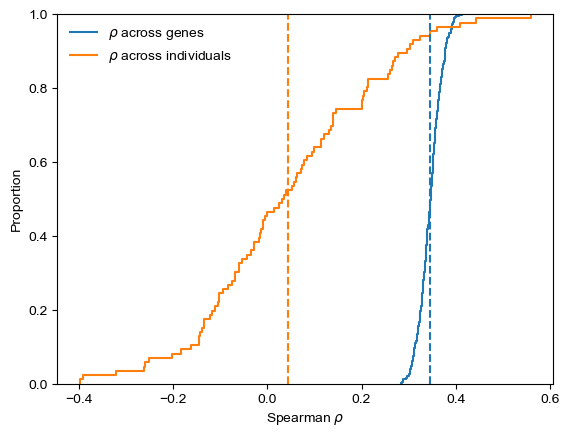

In [41]:
fig, ax = plt.subplots()
sns.ecdfplot(gene_rho.ravel(), label=r"$\rho$ across genes", ax=ax)
sns.ecdfplot(indiv_rho.ravel(), label=r"$\rho$ across individuals", ax=ax)
ax.axvline(np.nanmean(gene_rho), color="C0", linestyle="--")
ax.axvline(np.nanmean(indiv_rho), color="C1", linestyle="--")
ax.legend(loc="best")
ax.set(xlabel=r"Spearman $\rho$")